<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Dead Cat Drop Strategy](Introduction.ipynb) › Part 5: Short Sale Constraints
***

# Short Sale Constraints

So far we have assumed that we can sell short any stock we want, but this is not the case. We can only sell short if our broker has shares to loan us. QuantRocket maintains a store of shortable shares data from Interactive Brokers, which allows us to model this constraint. The dataset provides history back to April 16, 2018. 

## Shortable Shares data
 
First, we need to collect the data:

In [1]:
from quantrocket.fundamental import collect_ibkr_shortable_shares
collect_ibkr_shortable_shares(countries="japan")

{'status': 'the shortable shares data will be collected asynchronously'}

Monitor flightlog for a completion message:

```shell
quantrocket.fundamental: INFO Collecting ibkr japan shortable shares data from 2018-04-01 to present
quantrocket.fundamental: INFO Saved 1345685 total ibkr shortable shares records to quantrocket.v2.fundamental.ibkr.stockloan.shares.sqlite
```

## Strategy Code

In the strategy code, we implement short sale constraints in the `limit_position_sizes` method:

```python

def limit_position_sizes(self, prices):

    max_shares_for_shorts = None
        
    if self.CONSTRAIN_SHORTABLE:
        t = f"09:00:00 {self.TIMEZONE}"
        shortable_shares = get_ibkr_shortable_shares_reindexed_like(prices.loc["Close"], t)
        # constrain today's target weights by tomorrow's shortable shares, when the position will be entered
        max_shares_for_shorts = shortable_shares.shift(-1)

    return None, max_shares_for_shorts
```

We make the code conditional on a `CONSTRAIN_SHORTABLE` attribute, to allow us to easily run a parameter scan that compares the backtest result with and without the constraint. For more discussion, see the [usage guide](https://www.quantrocket.com/docs/#moonshot-short-sale-constraints).

## Shortable Shares Parameter Scan

For the period for which short sale data is available, we run a parameter scan to determine the effect of short sale constraints: 

In [2]:
from quantrocket.moonshot import scan_parameters
scan_parameters(
    "dead-cat-drop-japan", 
    start_date="2018-04-16", 
    end_date="2020-12-31",
    segment="Y",
    nlv={"JPY": 1e7},
    param1="CONSTRAIN_SHORTABLE",
    vals1=[True, False],
    filepath_or_buffer="dead_cat_drop_japan_CONSTRAIN_SHORTABLE.csv")

Then view the tear sheet:

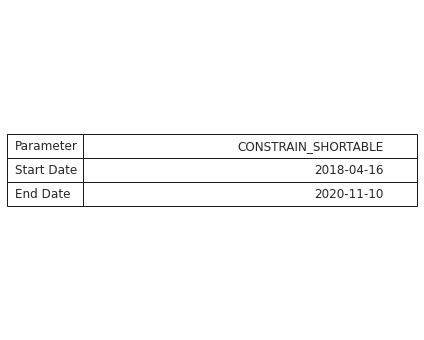

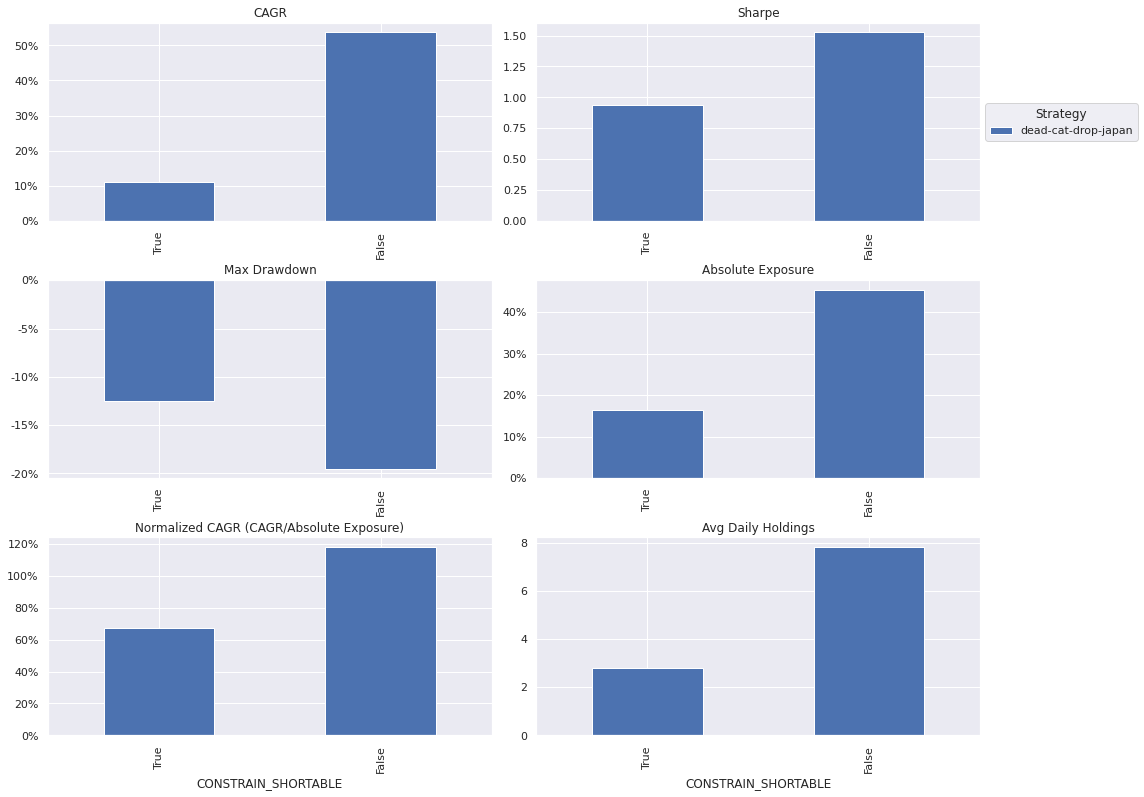

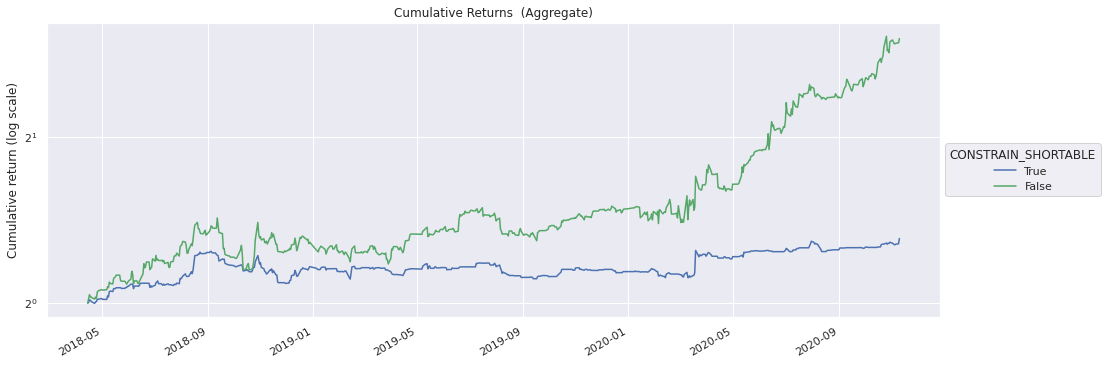

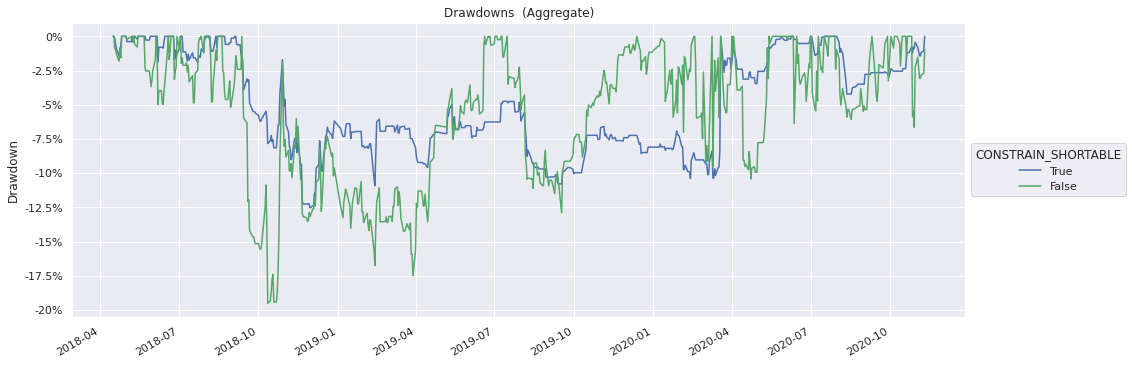

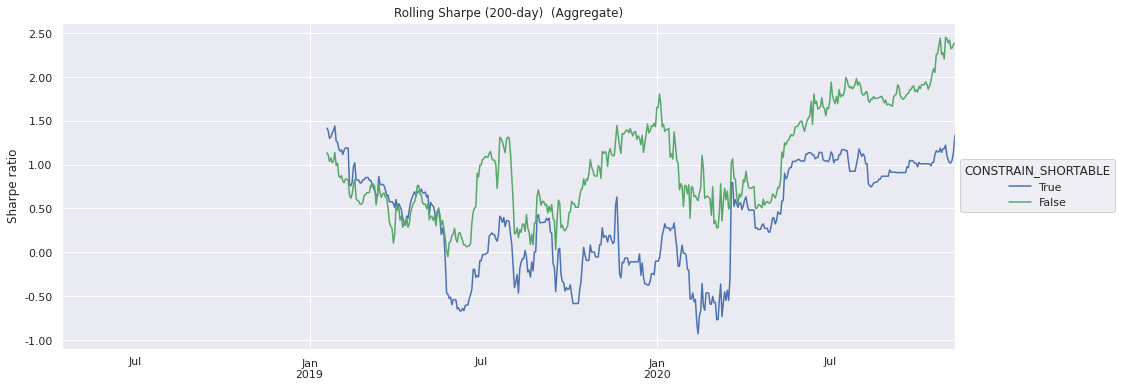

In [3]:
from moonchart import ParamscanTearsheet
ParamscanTearsheet.from_csv("dead_cat_drop_japan_CONSTRAIN_SHORTABLE.csv")

***

[Back to Introduction](Introduction.ipynb)